In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cd /content/drive/MyDrive/CMPE255_ASL_PROJECT

In [10]:
!unzip -q /content/drive/MyDrive/CMPE255_ASL_PROJECT/Data.zip

In [11]:
!ls asl_alphabet_train

asl_alphabet_train


In [12]:
!ls asl_alphabet_train

asl_alphabet_train


Filter out corrupted images (bad encoded)

In [13]:
train_dir = '/content/asl_alphabet_train/asl_alphabet_train'

batch_size = 32

trainingData = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=batch_size)

testingData = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [14]:
print(trainingData.class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


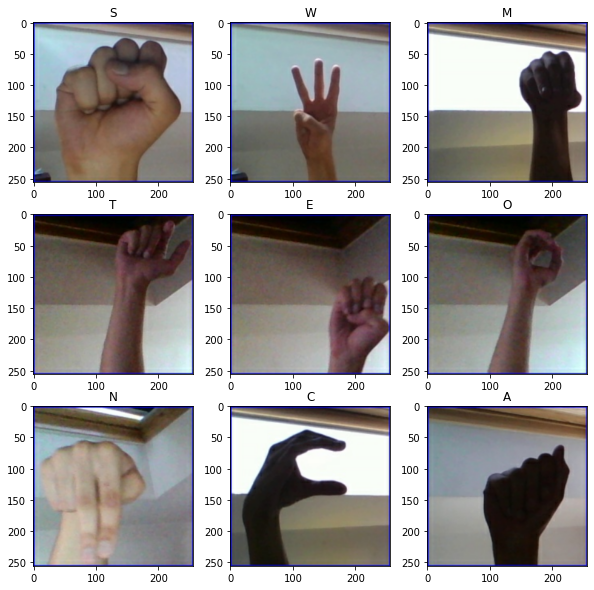

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, groundlabels in trainingData.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    classid=groundlabels[i].numpy()
    plt.title(trainingData.class_names[classid])
   

In [16]:
print(trainingData)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [17]:
print(testingData)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [18]:

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalizedData = trainingData.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalizedData))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9843138


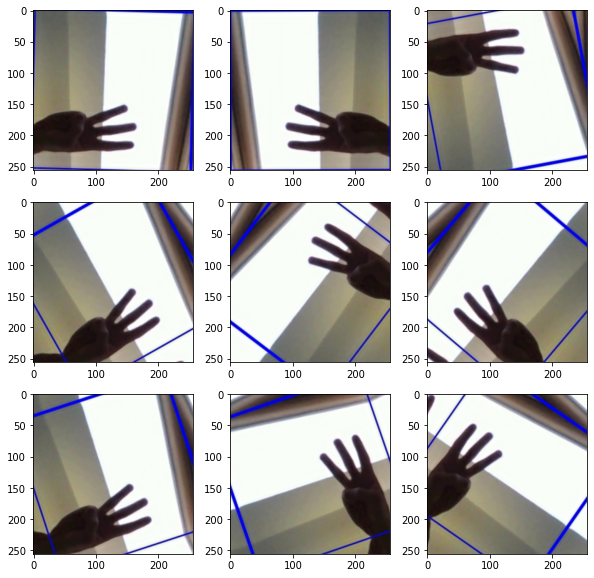

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])

for image, _ in trainingData.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)


In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [22]:
image_batch, label_batch = next(iter(trainingData))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [23]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(29)
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 29) dtype=float32, numpy=
 array([[ 0.05925625,  0.02709975, -0.00831097, ...,  0.00688563,
         -0.0461926 ,  0.04102831],
        [-0.03043568, -0.03786505,  0.05453736, ...,  0.03691706,
         -0.0251176 ,  0.03010271],
        [ 0.05078316, -0.06218945, -0.02633104, ...,  0.05380118,
          0.04874969,  0.01847041],
        ...,
        [ 0.0361454 , -0.0593035 , -0.0075001 , ..., -0.00437227,
         -0.0502413 ,  0.04962835],
        [ 0.03364726,  0.04725401,  0.00738081, ...,  0.05736149,
         -0.00239579, -0.02304444],
        [-0.00817053, -0.02485128, -0.0504374 , ...,  0.05988642,
          0.00774791,  0.05822162]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(29,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [27]:
initialLoss, initialAccuracy = model.evaluate(testingData)

544/544 [==============================] - 35s 61ms/step - loss: 3.6367 - accuracy: 0.0280


In [28]:
print("initial accuracy: "+str(initialAccuracy))
print("initial loss: "+str(initialLoss))


initial accuracy: 0.028045976534485817
initial loss: 3.636664628982544


In [29]:
history = model.fit(trainingData,
                    epochs=20,
                    validation_data=testingData)

Epoch 1/20
2175/2175 [==============================] - 206s 93ms/step - loss: 2.4553 - accuracy: 0.3297 - val_loss: 1.4975 - val_accuracy: 0.6693
Epoch 2/20
2175/2175 [==============================] - 202s 93ms/step - loss: 1.5245 - accuracy: 0.6018 - val_loss: 1.0428 - val_accuracy: 0.7653
Epoch 3/20
2175/2175 [==============================] - 202s 93ms/step - loss: 1.1932 - accuracy: 0.6882 - val_loss: 0.8366 - val_accuracy: 0.8065
Epoch 4/20
2175/2175 [==============================] - 202s 93ms/step - loss: 1.0173 - accuracy: 0.7291 - val_loss: 0.7151 - val_accuracy: 0.8309
Epoch 5/20
2175/2175 [==============================] - 200s 92ms/step - loss: 0.9038 - accuracy: 0.7580 - val_loss: 0.6434 - val_accuracy: 0.8464
Epoch 6/20
2175/2175 [==============================] - 201s 92ms/step - loss: 0.8318 - accuracy: 0.7754 - val_loss: 0.5988 - val_accuracy: 0.8513
Epoch 7/20
2175/2175 [==============================] - 201s 92ms/step - loss: 0.7748 - accuracy: 0.7876 - val_loss: 0

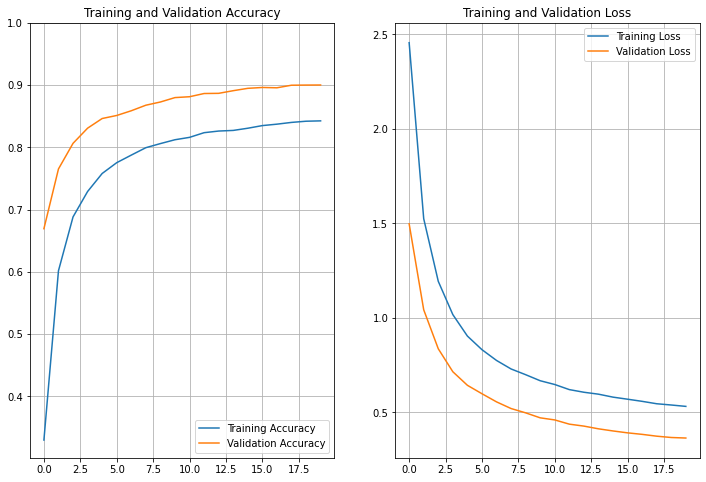

In [30]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()


plot_history(history, 'accuracy', 'val_accuracy')

In [31]:
model.save('saved_models/', save_format='tf')

In [32]:
model.save('model_mobileNetV2.h5')

## old

In [ ]:
import os

num_skipped=0
for folder_name in ("A","B","C","D","E","F","G","H","I","J","K"):
    folder_path = os.path.join("/content/asl_alphabet_train/asl_alphabet_train",folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)



Deleted 0 images


Dataset Generation

In [ ]:
import cv2
import numpy as np

In [ ]:
img = cv2.imread("/content/asl_alphabet_train/asl_alphabet_train/A/A1.jpg")

In [ ]:
img.shape

(200, 200, 3)

In [ ]:
image_size = (200, 200)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 87029 files belonging to 29 classes.
Using 69624 files for training.
Found 87029 files belonging to 29 classes.
Using 17405 files for validation.


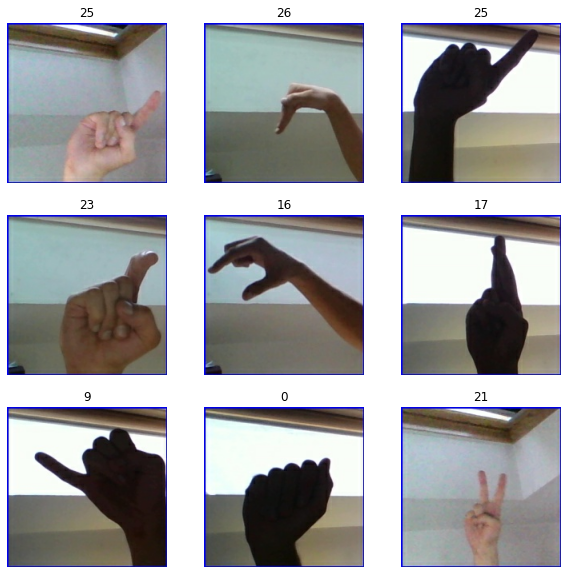

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


Apply Adjustment to image such as flip, rotate and shrink

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
    ]
)


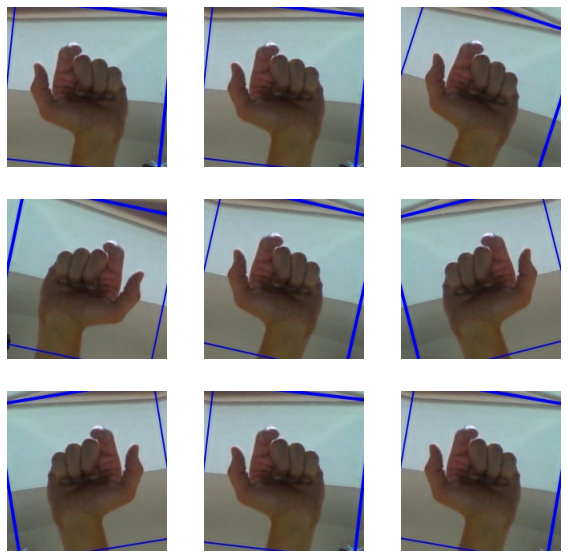

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [ ]:
tf.data.Dataset.save(train_ds,'/content/drive/MyDrive/CMPE255_ASL_PROJECT/preprocess_ds/val_ds_asl')